In [1]:
try:
    import openmdao.api as om
except ImportError:
    !python -m pip install openmdao[notebooks]
    import openmdao.api as om

# Determining Variable Shapes at Runtime
---

It's sometimes useful to create a component where the shapes of its inputs and/or outputs are
determined by their connections.  This allows us to create components representing general
purpose vector or matrix operations such as norms, summations, integrators, etc., that size
themselves appropriately based on the model that they're added to.

Turning on dynamic shape computation is straightforward.  You just specify `shape_by_conn`
and/or `copy_shape` in your `add_input` or `add_output` calls when you add variables
to your component.

Setting `shape_by_conn=True` when adding an input or output variable will allow the shape
of that variable to be determined at runtime based on the variable that connects to it.

Setting `copy_shape=<var_name>`, where `<var_name>` is the local name of another variable in your
component, will take the shape of the variable specified in `<var_name>` and use that
shape for the variable you're adding.  

Note that `shape_by_conn` can be specified for outputs as well as for inputs, as can `copy_shape`.
This means that shape information can propagate through the model in either forward or reverse. If
you specify both `shape_by_conn` and `copy_shape` for your component's dynamically shaped variables, 
it will allow your their shapes to be resolved whether known shapes have been defined upstream or 
downstream of your component in the model.

For example, the following component with input `x` and output `y` can have its shapes set by known shapes 
that are either upstream or downstream. Note that this component also has sparse partials, diagonal in this case, 
and those are specified within the `setup_partials` method which is called after all shapes have been computed.
It uses the `_get_var_meta` method to get the size of its variables in order to determine the size
of the partials.


In [2]:
class DynPartialsComp(om.ExplicitComponent):
    def setup(self):
        self.add_input('x', shape_by_conn=True, copy_shape='y')
        self.add_output('y', shape_by_conn=True, copy_shape='x')

    def setup_partials(self):
        size = self._get_var_meta('x', 'size')
        self.mat = np.eye(size) * 3.
        rng = np.arange(size)
        self.declare_partials('y', 'x', rows=rng, cols=rng, val=3.0)

    def compute(self, inputs, outputs):
        outputs['y'] = self.mat.dot(inputs['x'])

The following example demonstrates the flow of shape information in the forward direction, where the IndepVarComp has a known size, and the DynPartialsComp and the ExecComp are sized dynamically.

In [3]:
import numpy as np

p = om.Problem()
p.model.add_subsystem('indeps', om.IndepVarComp('x', val=np.ones(5)))
p.model.add_subsystem('comp', DynPartialsComp())
p.model.add_subsystem('sink', om.ExecComp('y=x',
                                          x={'shape_by_conn': True, 'copy_shape': 'y'},
                                          y={'shape_by_conn': True, 'copy_shape': 'x'}))
p.model.connect('indeps.x', 'comp.x')
p.model.connect('comp.y', 'sink.x')
p.setup()
p.run_model()
J = p.compute_totals(of=['sink.y'], wrt=['indeps.x'])
print(J['sink.y', 'indeps.x'])


[[ 3. -0. -0. -0. -0.]
 [-0.  3. -0. -0. -0.]
 [-0. -0.  3. -0. -0.]
 [-0. -0. -0.  3. -0.]
 [-0. -0. -0. -0.  3.]]


In [4]:
np.testing.assert_allclose(J['sink.y', 'indeps.x'], np.eye(5) * 3.)

And the following shows shape information flowing in reverse, from the known shape of `sink.x` to the unknown shape of the output `comp.y`, then to the input `comp.x`, then on to the connected auto-IndepVarComp output.

In [5]:
import numpy as np

p = om.Problem()
p.model.add_subsystem('comp', DynPartialsComp())
p.model.add_subsystem('sink', om.ExecComp('y=x', shape=5))
p.model.connect('comp.y', 'sink.x')
p.setup()
p.run_model()
J = p.compute_totals(of=['sink.y'], wrt=['comp.x'])
print(J['sink.y', 'comp.x'])


[[ 3. -0. -0. -0. -0.]
 [-0.  3. -0. -0. -0.]
 [-0. -0.  3. -0. -0.]
 [-0. -0. -0.  3. -0.]
 [-0. -0. -0. -0.  3.]]


In [6]:
np.testing.assert_allclose(J['sink.y', 'comp.x'], np.eye(5) * 3.)

## Debugging

Sometimes, when the shapes of some variables are unresolvable, it can be difficult to understand
why.  There is an OpenMDAO command line tool, `openmdao view_dyn_shapes`, that can be used to
show a graph of the dynamically shaped variables and any statically shaped variables that
connect directly to them.  Each node in the graph is a variable, and each edge is a connection
between that variable and another.  Note that this connection does not have to be a
connection in the normal OpenMDAO sense.  It could be a connection internal to a component
created by declaring a `copy_shape` in the metadata of one variable that refers to another
variable.

The nodes in the graph are colored to make it easier to locate static/dynamic/unresolved
variable shapes.  Statically shaped variables are colored green, dynamically shaped
variables that have been resolved are colored blue, and any variables with unresolved shapes
are colored red.  Each node is labeled with the shape of the variable, if known, or a '?' if
unknown, followed by the absolute pathname of the variable in the model.

The plot is somewhat crude and the node labels sometimes overlap, but it's possible to zoom
in to part of the graph to make it more readable using the button that looks like a magnifying glass.

Below is an example plot for a simple model with three components and no unresolved shapes.


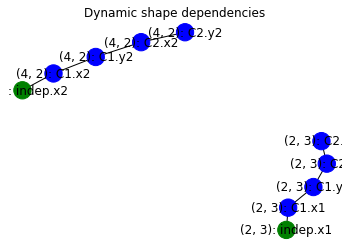

In [13]:
from openmdao.visualization.dyn_shape_plot import view_dyn_shapes
p = om.Problem()
indep = p.model.add_subsystem('indep', om.IndepVarComp('x1', val=np.ones((2,3))))
indep.add_output('x2', val=np.ones((4,2)))

p.model.add_subsystem('C1', om.ExecComp('y1, y2 = x1*2, x2*2',
                                                x1={'shape_by_conn': True, 'copy_shape': 'y1'},
                                                x2={'shape_by_conn': True, 'copy_shape': 'y2'},
                                                y1={'shape_by_conn': True, 'copy_shape': 'x1'},
                                                y2={'shape_by_conn': True, 'copy_shape': 'x2'}))

p.model.add_subsystem('C2', om.ExecComp('y1, y2 = x1*2, x2*2',
                                                x1={'shape_by_conn': True, 'copy_shape': 'y1'},
                                                x2={'shape_by_conn': True, 'copy_shape': 'y2'},
                                                y1={'shape_by_conn': True, 'copy_shape': 'x1'},
                                                y2={'shape_by_conn': True, 'copy_shape': 'x2'}))

p.model.connect('indep.x1', 'C1.x1')
p.model.connect('indep.x2', 'C1.x2')
p.model.connect('C1.y1', 'C2.x1')
p.model.connect('C1.y2', 'C2.x2')

p.setup()

view_dyn_shapes(p.model)

## Connecting Serial and Distributed Variables

Dynamically shaped connections between distributed outputs and serial inputs are not allowed because OpenMDAO assumes data will be transferred locally when computing variable shapes.  Since serial variables must be identical in size and value on all ranks where they exist, the distributed output would have to also be identical in size and value on all ranks.  If that is the case, then the output should just be serial as well.

Dynamically shaped connections between serial outputs and distributed inputs are currently allowed but are deprecated and will raise an exception in a future release. Their use is not recommended. Such connections require
that all src_indices in all ranks of the distributed input are identical.